# Causal Diagrams to compute Causal Inference

In this tutorial we will investigate some dangers of relying only on observational data and traditional machine learning models to compute causal effects

# Data

We will make use of fklearn builtin make_confounded_data method to generate synthetic data for us

In [3]:
import numpy as np
import pandas as pd

from fklearn.training.regression import xgb_regression_learner
from fklearn.training.classification import xgb_classification_learner, logistic_classification_learner
# from fklearn.training.causal_inference import IPTW_learner
from fklearn.validation.evaluators import r2_evaluator, roc_auc_evaluator
from fklearn.data.datasets import make_confounded_data

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("max_columns", 500)

N=10000

features = ["sex", "age", "severity"]
treatment = ["medication"]

np.random.seed(42)

In [6]:
import fklearn
fklearn.__version__

'1.18.0'

In [7]:
pd.__version__

'0.24.0'

In [8]:
np.__version__

'1.16.6'

In [5]:
df_rnd, df_obs, df_cf = make_confounded_data(N)

In [6]:
df_rnd.head()

,sex,age,severity,medication,recovery
0,0,35.857725,0.713511,0,35
1,1,26.162705,0.191286,1,9
2,1,25.284784,0.010045,1,11
3,1,41.616736,0.858321,0,107
4,0,22.062427,0.008502,1,5


In [7]:
df_obs.corr()

,sex,age,severity,medication,recovery
sex,1.000000,0.020541,0.022876,0.226197,0.289954
age,0.020541,1.000000,0.557409,0.470338,0.598271
severity,0.022876,0.557409,1.000000,0.799194,0.172188
medication,0.226197,0.470338,0.799194,1.000000,-0.085889
recovery,0.289954,0.598271,0.172188,-0.085889,1.000000


In [8]:
df_rnd.corr()

,sex,age,severity,medication,recovery
sex,1.000000,0.020541,0.022876,0.002773,0.289559
age,0.020541,1.000000,0.557409,-0.005334,0.606501
severity,0.022876,0.557409,1.000000,-0.013713,0.514881
medication,0.002773,-0.005334,-0.013713,1.000000,-0.522704
recovery,0.289559,0.606501,0.514881,-0.522704,1.000000


$Sex \sim  \mathcal{B}(0.5)$

$Age \sim \operatorname{Gamma}(8, 4)$

$Severity \sim \mathbb{1}_{\{age \lt 30\}} \operatorname{Beta}(1,3) + \mathbb{1}_{\{age \geq 30\}} \operatorname{Beta}(3,1.5)$

$Medication \sim \mathcal{B}(-0.8 + 0.33*sex + 1.5*severity)$

$Recovery = \operatorname{Poisson}(2+0.5 * sex+0.03 * age+ 1*severity-1 * medication)$


Looking at the recovery formula, the linear factor that multiply the medication is `−1`. 

This relation is inside a Poisson model, so the expected causal effect of medication on recovery time is
`𝑒𝑥𝑝(−1)≈0.36`.

# Let's represent the observational process as a causal diagram

In [9]:
from causalnex.structure import StructureModel
sm = StructureModel()

In [10]:
sm.add_edges_from([
    ('sex', 'medication'),
    ('sex', 'recovery'),
    ('age', 'severity'),
    ('age', 'recovery'),
    ('severity', 'medication'),
    ('severity', 'recovery'),
    ('medication', 'recovery')
])

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'sex', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


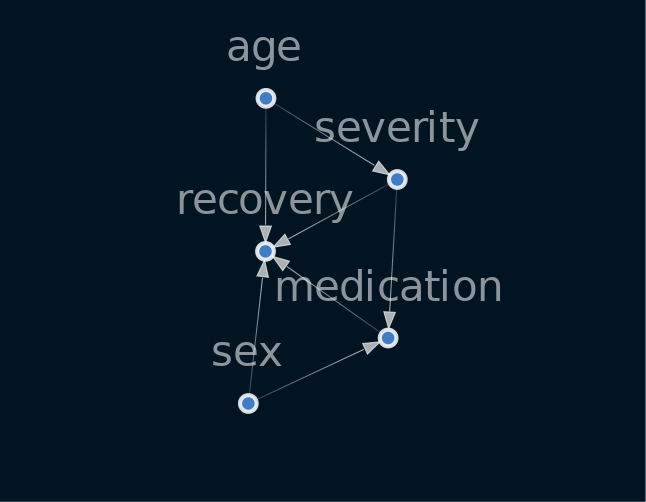

In [11]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

We are interested in measuring the effectiveness of treatment (medication) on recovery. Our observational data may be introducing bias on the measure. Treatment in our synthetically generated observation data is influenced by sex, by severity and by age proxied by severity. This simulates a real world scenario where we are often dealing with data that is generated by a non-random process.

An interested reader may ask: but Gustavo, recovery is also influenced by these same factors, wouldn't it be cancelled then? It isn't that simple...

The problem we are dealing here is confounding. Both medication and recovery on our Causal Diagram have arrows coming from sex, severity and indirectly, age. On our observational data these variables are common causes of medication and recovery, so we may be measuring indirect effects while we are trying to isolate the effect of medication on recovery.

To mitigate this problem we should eliminate our arrows arriving at medication by assigning treatment groups randomly. fklearn's function automatically did this for the `df_rnd` data

# The random medication assignment would lead to a causal diagram like this

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'sex', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


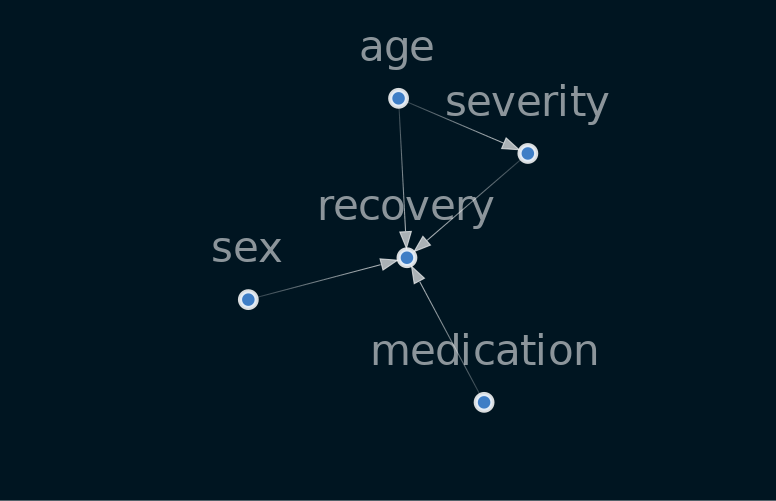

In [12]:
sm.remove_edges_from([
    ('sex', 'medication'),
    ('severity', 'medication'),
])

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

In this scenario we can measure the effect of medication on recovery directly without confounders

# Confounding

![](Confounding.png)
*Source:(https://en.wikipedia.org/wiki/Confounding)*


$P(y\mid do(x))=\sum _{z}P(y\mid x,z)P(z)$ 


## Fitting simple models to observational/random data

In [13]:
regr_learner = xgb_regression_learner(features=features + treatment, target="recovery")

# Random data

In [14]:
sem_fn, df_rnd, _ = regr_learner(df_rnd)

[18:57:12] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:13] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
X_neg = df_rnd.copy()
X_pos = df_rnd.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds_rnd = sem_fn(X_pos)["prediction"] / sem_fn(X_neg)["prediction"]
preds_rnd.mean()

0.36662948

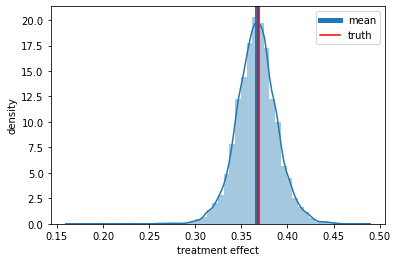

In [16]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_rnd), label='mean', lw=5)
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

In [17]:
sem_fn, df_obs, _ = regr_learner(df_obs)

[18:57:14] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:14] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


In [18]:
X_neg = df_obs.copy()
X_pos = df_obs.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds_obs = sem_fn(X_pos)["prediction"] / sem_fn(X_neg)["prediction"]
preds_obs.mean()

0.42997646

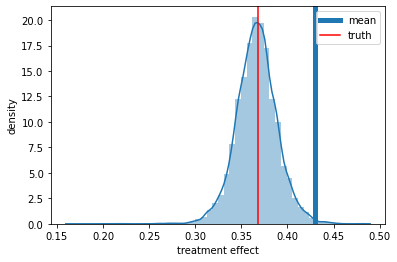

In [19]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_obs), label='mean', lw=5)
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

In [20]:
eval_fn = r2_evaluator(prediction_column="prediction",target_column="recovery")

print("Factual Evaluation:", eval_fn(sem_fn(df_obs)))
print("Counter Factual Evaluation", eval_fn(sem_fn(df_cf)))

Factual Evaluation: {'r2_evaluator__recovery': 0.879843582410846}
Counter Factual Evaluation {'r2_evaluator__recovery': 0.8037818950149086}


# Learning the Structure automatically with CausalNex

>As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data.

In [21]:
# Running again to start from scratch (without predictions)
N = 10000
df_rnd, df_obs, df_cf = make_confounded_data(N)

In [22]:
from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

sm = from_pandas(df_obs)

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'sex', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


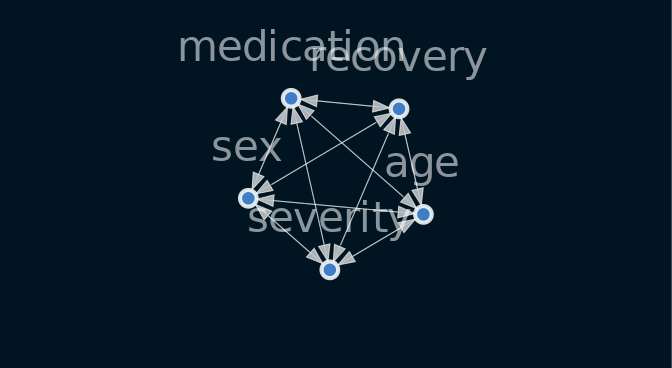

In [23]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./causalnex_structure_model.png"
viz.draw(filename)
Image(filename)

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'sex', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


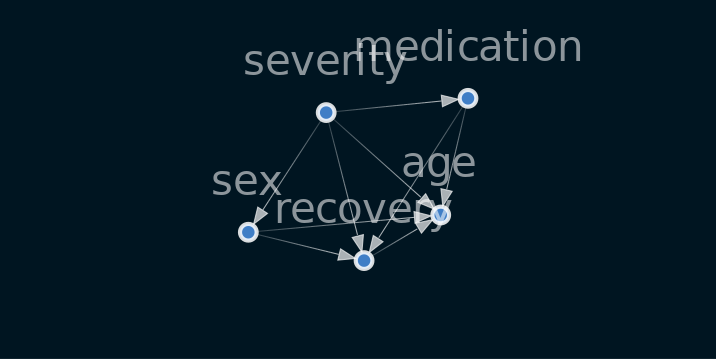

In [24]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./causalnex_structure_model.png"
viz.draw(filename)
Image(filename)

Well, causalnex didn't help much here. We see multiple wrong arrow directions here. This is expected, from the [F.A.Q.](https://causalnex.readthedocs.io/en/stable/05_resources/05_faq.html) we learn that the NOTEARS algorithm expects a continuous dataset to work properly:

> "NOTEARS works by detecting if a small increase in the value of the node will result in an increase in another node. If there is, NOTEARS will be able to capture this and assert that this is a causal relationship. Therefore, we highly recommend that the dataset to be used is continuous."

We can help the algorithm by listing some Tabu edges

# Incorporating domain knowledge 
We still miss several edges here. CausalNex allows us to incorporate domain knowledge to our StructuredModel

In [25]:
sm = from_pandas(df_rnd, 
                 tabu_child_nodes=['age', 'sex', 'medication'], 
                 tabu_parent_nodes=['recovery'], 
                 tabu_edges=[('medication', 'severity'),
                             ('sex', 'severity')])

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'sex', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


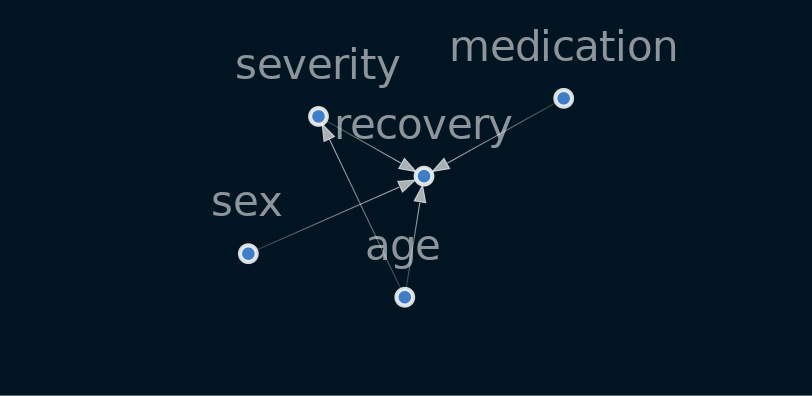

In [26]:
# sm.remove_edges_below_threshold(0.01)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./causalnex_structure_model.png"
viz.draw(filename)
Image(filename)

In [27]:
N = 10000
df_rnd, df_obs, df_cf = make_confounded_data(N)

# Discretising the data

> Bayesian Networks in CausalNex support only discrete distributions. Any continuous features, or features with a large number of categories, should be discretised prior to fitting the Bayesian Network. Models containing variables with many possible values will typically be badly fit, and exhibit poor performance.

In [28]:
def make_discretised_data(data: pd.DataFrame) -> pd.DataFrame:
    discretised_data = data.copy()
    discretised_data["medication"] = discretised_data["medication"].astype(int)
    discretised_data["age"] = pd.qcut(discretised_data["age"], 
                                  q=3,
                                  labels=["young", "adult", "elder"])
    discretised_data["severity"] = pd.qcut(discretised_data["severity"], 
                                           q=3, 
                                           labels=["low-severity", "medium-severity", "high-severity"])
    discretised_data["recovery"] = pd.qcut(discretised_data["recovery"], 
                                           q=2, 
                                           labels=['fast-recovery', 'slow-recovery'])
    
    return discretised_data

In [30]:
discretised_data_rnd = make_discretised_data(df_rnd)

In [32]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data_rnd, train_size=0.9, test_size=0.1, random_state=42)

In [34]:
bn = bn.fit_node_states(discretised_data_rnd)

In [35]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pandas/core/generic.py:5069: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/pandas/core/generic.py:5070: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [36]:
bn.cpds["recovery"]

age                   adult                                                   \
medication                0                                                    
severity      high-severity           low-severity           medium-severity   
sex                       0         1            0         1               0   
recovery                                                                       
fast-recovery      0.007326  0.003484     0.756303  0.123711        0.211155   
slow-recovery      0.992674  0.996516     0.243697  0.876289        0.788845   

age                                                                     \
medication                          1                                    
severity                high-severity           low-severity             
sex                   1             0         1            0         1   
recovery                                                                 
fast-recovery  0.003759      0.937008  0.346535     0.995575  0.983122   
slow-recovery  0.996241      0.062992  0.653465     0.004425  0.016878   

age                                             elder                         \
medication                                          0                          
severity      medium-severity           high-severity           low-severity   
sex                         0         1             0         1            0   
recovery                                                                       
fast-recovery           0.996  0.874477      0.002257  0.002049     0.047619   
slow-recovery           0.004  0.125523      0.997743  0.997951     0.952381   

age                                                                      \
medication                                                  1             
severity               medium-severity          high-severity             
sex                  1               0        1             0         1   
recovery                                                                  
fast-recovery  0.03125         0.01083  0.00369      0.581731  0.071599   
slow-recovery  0.96875         0.98917  0.99631      0.418269  0.928401   

age                                                                    young  \
medication                                                                 0   
severity      low-severity           medium-severity           high-severity   
sex                      0         1               0         1             0   
recovery                                                                       
fast-recovery     0.965517  0.605263        0.881579  0.386617      0.153846   
slow-recovery     0.034483  0.394737        0.118421  0.613383      0.846154   

age                                                                       \
medication                                                                 
severity                low-severity           medium-severity             
sex                   1            0         1               0         1   
recovery                                                                   
fast-recovery  0.028571     0.952191  0.428875        0.705882  0.089623   
slow-recovery  0.971429     0.047809  0.571125        0.294118  0.910377   

age                                                                          \
medication                1                                                   
severity      high-severity           low-severity          medium-severity   
sex                       0         1            0        1               0   
recovery                                                                      
fast-recovery      0.971429  0.897436     0.998054  0.99789         0.99569   
slow-recovery      0.028571  0.102564     0.001946  0.00211         0.00431   

age                      
medication               
severity                 
sex                   1  
recovery                 
fast-recovery  0.991031  
slow-recovery  0.008969

In [37]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "recovery")
print(auc)

0.9645870000000001


In [38]:
bn = bn.fit_cpds(discretised_data_rnd, method="BayesianEstimator", bayes_prior="K2")

In [41]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["recovery"]

{'fast-recovery': 0.5007351469145527, 'slow-recovery': 0.49926485308544705}

In [42]:
import numpy as np
labels, counts = np.unique(discretised_data_rnd["recovery"], return_counts=True)
list(zip(labels, counts))

[('fast-recovery', 5108), ('slow-recovery', 4892)]

In [43]:
marginals_short = ie.query({"medication": 1})
marginals_long = ie.query({"medication": 0})
print("Marginal recovery | Medication", marginals_short["recovery"])
print("Marginal recovery | No-Medication", marginals_long["recovery"])

Marginal recovery | Medication {'fast-recovery': 0.805343029756816, 'slow-recovery': 0.19465697024318399}
Marginal recovery | No-Medication {'fast-recovery': 0.19855393511664146, 'slow-recovery': 0.8014460648833586}


# What if we look only at sex = 1?

In [44]:
print("marginal recovery", ie.query()["recovery"])
ie.do_intervention(
    "sex",
    {
        0: 0.0,
        1: 1.0
    },
)
print("updated marginal recovery", ie.query()["recovery"])

marginal recovery {'fast-recovery': 0.5007351469145527, 'slow-recovery': 0.49926485308544705}
updated marginal recovery {'fast-recovery': 0.3791686332072646, 'slow-recovery': 0.6208313667927353}


In [45]:
ie.reset_do("sex")

# Let's investigate the observational data now

In [46]:
discretised_data_obs = make_discretised_data(df_obs)

In [47]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

In [48]:
bn = bn.fit_node_states(discretised_data_obs)

In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data_obs, train_size=0.9, test_size=0.1, random_state=42)

In [50]:
bn = bn.fit_cpds(discretised_data_obs, method="BayesianEstimator", bayes_prior="K2")

In [51]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "recovery")
print(auc)

0.904601


In [52]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["recovery"]

{'fast-recovery': 0.5211113797990666, 'slow-recovery': 0.4788886202009333}

In [53]:
import numpy as np
labels, counts = np.unique(discretised_data_obs["recovery"], return_counts=True)
list(zip(labels, counts))

[('fast-recovery', 5314), ('slow-recovery', 4686)]

In [54]:
marginals_short = ie.query({"medication": 1})
marginals_long = ie.query({"medication": 0})
print("Marginal recovery | Medication", marginals_short["recovery"])
print("Marginal recovery | No-Medication", marginals_long["recovery"])

Marginal recovery | Medication {'fast-recovery': 0.7081887807396127, 'slow-recovery': 0.29181121926038744}
Marginal recovery | No-Medication {'fast-recovery': 0.29937336360888517, 'slow-recovery': 0.7006266363911148}


In [55]:
print("marginal recovery", ie.query()["recovery"])
ie.do_intervention("medication",
                   {0: 0.0,
                    1 : 1.0})
print("updated marginal recovery", ie.query()["recovery"])

marginal recovery {'fast-recovery': 0.5211113797990666, 'slow-recovery': 0.4788886202009333}
updated marginal recovery {'fast-recovery': 0.7081887807396124, 'slow-recovery': 0.2918112192603875}


In [56]:
ie.reset_do("medication")

In [57]:
print("marginal recovery", ie.query()["recovery"])
ie.do_intervention(
    "sex",
    {
        0: 0.0,
        1: 1.0
    },
)
ie.do_intervention("medication",
                   {0: 0.0,
                    1 : 1.0})
print("updated marginal recovery", ie.query()["recovery"])

marginal recovery {'fast-recovery': 0.5211113797990666, 'slow-recovery': 0.4788886202009333}
updated marginal recovery {'fast-recovery': 0.6611684864413222, 'slow-recovery': 0.3388315135586777}


In [58]:
ie.reset_do("sex")
ie.reset_do("medication")

In [59]:
marginals

{'sex': {0: 0.5033993201359727, 1: 0.4966006798640271},
 'recovery': {'fast-recovery': 0.5211113797990666,
  'slow-recovery': 0.4788886202009333},
 'age': {'adult': 0.3333000099970009,
  'elder': 0.3333000099970009,
  'young': 0.3333999800059982},
 'severity': {'high-severity': 0.3333333333333333,
  'low-severity': 0.33333333333333326,
  'medium-severity': 0.3333333333333333},
 'medication': {0: 0.4576084783043391, 1: 0.5423915216956606}}

As we saw, there are some drawbacks from using Bayesian networks

## Drawbacks
- Granularity of modelling may have to be lower. However, this may either not be necessary, or can be run in tangent to other techniques that provide accuracy but are less interpretable;
- Computational complexity is higher. However, this can be offset with careful feature selection and a less granular discretisation policy, but at the expense of predictive power;

# Do-Why

> DoWhy provides a unified interface for causal inference methods and automatically tests many assumptions, thus making inference accessible to non-experts.

1. Provides a principled way of modeling a given problem as a causal graph so that all assumptions are explicit.
2. Provides a unified interface for many popular causal inference methods, combining the two major frameworks of graphical models and potential outcomes.
3. Automatically tests for the validity of assumptions if possible and assesses the robustness of the estimate to violations.

In [92]:
from dowhy import CausalModel

In [93]:
N = 1000000
df_rnd, df_obs, df_cf = make_confounded_data(N)

int -> 'c'

float -> 'c'

binary -> 'b'

category -> 'd'

In [94]:
df_rnd['medication'] = df_rnd['medication'].astype(bool)
df_obs['medication'] = df_obs['medication'].astype(bool)

In [107]:
# Create a causal model from the data and given graph.
model = CausalModel(
    data=df_obs,
    treatment="medication",
    outcome="recovery",
    graph="digraph {medication -> recovery; sex -> recovery; severity -> recovery; sex -> medication; severity -> medication; age -> severity; age -> recovery}",
    variable_types={
        "medication": "b",
        "recovery": "c",
        "sex": "b",
        "severity": "c",
        "age": "c",
    },
)

# Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(
    identified_estimand,
    control_value=0,
    treatment_value=1,
    test_significance=True,
    method_name="backdoor.linear_regression",
)

# Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. generator raised StopIteration
Trying pydot ...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['medication'] on outcome ['recovery']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['age', 'severity', 'sex', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: recovery~medication+age+severity+sex


                            OLS Regression Results                            
Dep. Variable:               recovery   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                 7.894e+05
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        09:17:05   Log-Likelihood:            -3.2899e+06
No. Observations:             1000000   AIC:                         6.580e+06
Df Residuals:                  999995   BIC:                         6.580e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4298      0.021   -303.019      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: recovery~medication+age+severity+sex+w_random


                            OLS Regression Results                            
Dep. Variable:               recovery   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                 6.315e+05
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        09:17:07   Log-Likelihood:            -3.2899e+06
No. Observations:             1000000   AIC:                         6.580e+06
Df Residuals:                  999994   BIC:                         6.580e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4298      0.021   -303.018      0.0

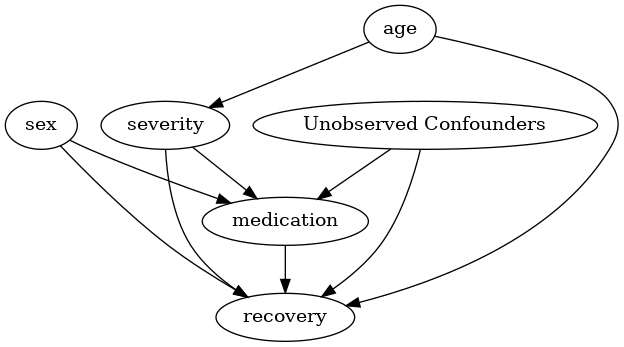

In [108]:
from IPython.display import Image, display

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [109]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                              
─────────────(Expectation(recovery|age,severity,sex))
d[medication]                                        
Estimand assumption 1, Unconfoundedness: If U→{medication} and U→recovery then P(recovery|medication,age,severity,sex,U) = P(recovery|medication,age,severity,sex)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: recovery~medication+age+severity+sex
Target units: ate

## Estimate
Mean value: -25.019703139251842
p-value: [0.]



In [110]:
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-25.019703139251842
New effect:-25.019682777607045



In [99]:
# Create a causal model from the data and given graph.
model = CausalModel(
    data=df_rnd,
    treatment="medication",
    outcome="recovery",
    graph="digraph {medication -> recovery; sex -> recovery; severity -> recovery; age -> severity; age -> recovery}",
    variable_types={
        "medication": "b",
        "recovery": "c",
        "sex": "b",
        "severity": "c",
        "age": "c",
    },
)

# Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(
    identified_estimand,
    control_value=0,
    treatment_value=1,
    test_significance=True,
    method_name="backdoor.linear_regression",
)

# Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. generator raised StopIteration
Trying pydot ...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['medication'] on outcome ['recovery']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: recovery~medication+medication*age+medication*severity+medication*sex


                            OLS Regression Results                            
Dep. Variable:               recovery   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                 1.323e+05
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        09:16:10   Log-Likelihood:            -4.5663e+06
No. Observations:             1000000   AIC:                         9.133e+06
Df Residuals:                  999995   BIC:                         9.133e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7664      0.033   1452.227      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: recovery~medication+w_random+medication*age+medication*severity+medication*sex


                            OLS Regression Results                            
Dep. Variable:               recovery   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                 1.058e+05
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        09:16:12   Log-Likelihood:            -4.5663e+06
No. Observations:             1000000   AIC:                         9.133e+06
Df Residuals:                  999994   BIC:                         9.133e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7665      0.033   1452.228      0.0

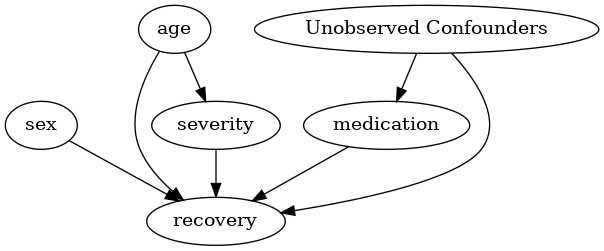

In [100]:
from IPython.display import Image, display

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [101]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                             
─────────────(Expectation(recovery))
d[medication]                       
Estimand assumption 1, Unconfoundedness: If U→{medication} and U→recovery then P(recovery|medication,,U) = P(recovery|medication,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: recovery~medication+medication*age+medication*severity+medication*sex
Target units: ate

## Estimate
Mean value: -30.17633551585639
p-value: [0.]
### Conditional Estimates
__categorical__age  __categorical__severity  __categorical__sex
(3.262, 22.297]     (-0.000999966, 0.162]    (-0.001, 1.0]        -44.502352
                    (0.162, 0.364]           (-0.001, 1.0]        -42.077056
                    (0.364, 0.572]           (-0.001, 1.0]        -39.322248
                    (0.572, 0.765]           (-0.001, 1.0]      

In [102]:
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-30.17633551585639
New effect:-30.17638113894845



# CFML_tools

In [4]:
# Source: https://github.com/gdmarmerola/cfml_tools

import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from pynndescent import NNDescent

# class for computing effects using forest embeddings
class ForestEmbeddingsCounterfactual:
    
    """
    Counterfactual estimation using forest embeddings.
    Given explanatory variables X, target variable y and treatment variable W, 
    this class implements an individual counterfactual estimation model. 
    We can break down the process in four steps:
    1 - model step) Fit and validate an ensemble of trees (ET, RF, etc) from X to y
    2 - embedding step) Build a supervised embedding using forest's trees leaves
    3 - kNN step) For each sample, find K nearest neighbors in this new space 
    4 - comparison step) Compare W and y for each of the neighborhoods to determine the counterfactuals for each sample
    Parameters
    ----------
    model : object, optinal (default=None)
    Forest-based model which implements sklearn's API, particularly the .apply() method. 
    Must be already configured. Classification and regression models accepted.
    If None, model will be ExtraTreesRegressor(n_estimators=1000, min_samples_leaf=5, bootstrap=True, n_jobs=-1).
    n_neighbors : int, optional (default=200)
    Number of neighbors to be considered at the kNN step. There's a bias-variance tradeoff here: 
    set n_neighbors too low, estimates will be volatile and unreliable. 
    Set n_neighbors too high, and the estimate will be biased (neighbors won't be comparable). 
    min_sample_effect : int, optional (default=10)
    The minimum number of samples in a neighborhood for the counterfactual estimate to be valid, for a given W. 
    If there's less treated/untreated elements than min_sample_effect in a neighborhood, the counterfactual will be NaN.
    save_explanatory : bool, optional (default=False)
    Save explanatory variables for explaining predictions. May cause large memory overhead.
    random_state : int, optional (default=None)
    If int, random_state is the seed used by the random number generator;
    If RandomState instance, random_state is the random number generator;
    If None, the random number generator is the RandomState instance used
    by `np.random`.
    
    """   

    # initializing
    def __init__(self, model=None, n_neighbors=200, min_sample_effect=10, save_explanatory=False, random_state=None):

        # storing model
        if model == None:
            self.model = ExtraTreesRegressor(n_estimators=1000, min_samples_leaf=5, bootstrap=True, n_jobs=-1)
        else:
            self.model = model

        # storing variables
        self.n_neighbors = int(n_neighbors)
        self.min_sample_effect = int(min_sample_effect)
        self.save_explanatory = save_explanatory
        self.random_state = random_state

    # method for computing embedding
    def _get_forest_embed(self, X):

        """
        Wrapper for extracting embeddings from forests given selected mode.
        Model must be fitted.
        """

        # applying the model to get leaves
        this_embed = self.model.apply(X)

        # returning forest embedding
        return this_embed


    # fit model and neighbors
    def fit(self, X, W, y, verbose=0):

        """
        Fit a counterfactual estimation model given explanatory variables X, treatment variable W and target y
        This method fits a forest-based model, extracts a supervised embedding from its leaves, 
        and builds an nearest neighbor index on the embedding
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        W : array-like, shape = [n_samples] 
        Treatment variable. The model will try to estimate a counterfactual outcome for each unique value in this variable.
        Should not exceed 10 values.
        y: array-like, shape = [n_samples]
    
        Target variable. 
        verbose : int, optional (default=0)
        Verbosity level.
        Returns
        -------
        self: object
        """
        
        # checking if W has too many unique values
        if len(np.unique(W)) > 10:
            raise ValueError('More than 10 unique values for W. Too many unique values will make the process very expensive.')

        # fitting the model
        self.model.fit(X, y)

        # getting forest embedding from model
        self.train_embed_ = self._get_forest_embed(X)

        # create neighbor index
        self.nn_index = NNDescent(self.train_embed_, metric='hamming')

        # creating a df with treatment assignments and outcomes
        self.train_outcome_df = pd.DataFrame({'neighbor': range(X.shape[0]), 'y': y, 'W': W})

        # saving explanatory variables
        if self.save_explanatory:
            self.X_train = X.assign(W=W, y=y)

        # return self
        return self

    # method for predicting counterfactuals
    def predict(self, X, verbose=0):

        """
        Predict counterfactual outcomes for X. 
        This method will search the nearest neighbor index built using .fit(), and estimate
        counterfactual outcomes using kNN
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        verbose : int, optional (default=0)
        Verbosity level.
        Returns
        -------
        
        counterfactual_df : pd.DataFrame
        Counterfactual outcomes per sample.
        """

        # getting forest embedding from model
        X_embed_ = self._get_forest_embed(X)

        # getting nearest neighbors and distances from index
        neighs, dists = self.nn_index.query(X_embed_, k=self.n_neighbors + 1)
                        
        # creating a df for neighbor ids
        neighs_df = (pd.DataFrame(neighs)
                     .reset_index()
                     .melt(id_vars='index')
                     .rename(columns={'index':'id','value':'neighbor'})
                     .reset_index(drop=True))

        # creating a df for the similarities
        similarities_df = (pd.DataFrame(1 - dists)
                           .reset_index()
                           .melt(id_vars='index')
                           .rename(columns={'index':'id','value':'weight'})
                           .reset_index(drop=True))

        # joining the datasets and adding weighted y variable
        nearest_neighs_df = (neighs_df
                             .merge(similarities_df)
                             .drop('variable', axis=1)
                             .merge(self.train_outcome_df, on='neighbor', how='left')
                             .assign(y_weighted = lambda x: x.y*(x.weight))
                             .sort_values('id'))
        
        # processing to get the effects
        counterfactual_df = nearest_neighs_df.assign(count=1).groupby(['id','W']).sum()
        #counterfactual_df['y_hat'] = counterfactual_df['y']/counterfactual_df['count']
        counterfactual_df['y_hat'] = counterfactual_df['y_weighted']/counterfactual_df['weight']
        counterfactual_df.loc[counterfactual_df['count'] < self.min_sample_effect,'y_hat'] = np.nan
        counterfactual_df = counterfactual_df.pivot_table(values=['y_hat'], columns='W', index='id')
        
        # returning counterfactual df
        return counterfactual_df


    # running CV for model parameters
    def get_cross_val_scores(self, X, y, scoring=None, verbose=0):

        """
        Estimate model generalization power with 5-fold CV.
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        y: array-like, shape = [n_samples]
        Target variable. 
        
        scoring : string, callable or None, optional, default: None
        
        Scoring method for sklearn's cross_val_score function:
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)`` which should return only
        a single value.
        Similar to :func:`cross_validate`
        but only a single metric is permitted.
        If None, the estimator's default scorer (if available) is used.
        
        verbose : int, optional (default=0)
        Verbosity level for sklearn's function cross_val_score.
        Returns
        -------
        
        scores : array of float, shape=(len(list(cv)),)
        Array of scores of the estimator for each run of the cross validation.
        
        """
        
        # CV method
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)

        # generating validation predictions
        scores = cross_val_score(self.model, X, y, cv=kf, scoring=scoring, verbose=verbose)

        # calculating result
        return scores

    # generating manifold with UMAP
    def get_umap_embedding(self, X, verbose=0):

        """
        Compute a 2D manifold from the forest embedding for validation and criticism.
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        verbose : int, optional (default=0)
        Verbosity level for UMAP.
        Returns
        -------
        
        reduced_embed : array of shape = [n_samples, 2]
        2D representation of forest embedding using UMAP. 
        """
        
        # getting forest embedding from model
        X_embed_ = self._get_forest_embed(X)

        # reducing embedding to 2 dimensions
        reduced_embed = UMAP(metric='hamming', verbose=verbose).fit_transform(X_embed_)
        
        # returning 
        return reduced_embed

    # method for explaning predictions
    def explain(self, sample):

        """
        Explain predcitions of counterfactual outcomes for one sample. 
        This method shows diagnostics and comparables so you can trust
        and explain counterfactual predictions to others
        Parameters
        ----------
        
        sample : array-like or sparse matrix of shape = [1, n_features]
        
        Sample that you want to get explanations for
        Returns
        -------
        
        comparables_table : pd.DataFrame
        Table of comparable elements.
        """

        # getting forest embedding from model
        sample_embed = self._get_forest_embed(sample)

        # getting nearest neighbors and distances from index
        neighs, dists = self.nn_index.query(sample_embed, k=self.n_neighbors + 1)

        # querying comparables
        try:
            comparables_table = self.X_train.iloc[neighs[0]]
        except Exception as e:
            raise type(e)('Model did not store training samples to get explanations from. Setting save_explanatory=True should solve the issue')

        # returning comparables table
        return comparables_table
    
# class for using a decision tree to compute effects
class DecisionTreeCounterfactual:

    """
    Counterfactual estimation using a decision tree.
    Given explanatory variables X, target variable y and treatment variable W, 
    this class implements an individual counterfactual estimation model. 
    We can break down the process in three steps:
    1 - model step) Fit a decision tree to X and y
    2 - comparison step) at each of the tree's leaves, compare W and y to determine the counterfactuals for the leaf 
    3 - prediction step) assign new samples to a leaf, and predict counterfactuals
    Parameters
    ----------
    model : object, optinal (default=None)
    Tree-based model which implements sklearn's API, particularly the .apply() method.
    Must be already configured.
    If None, model will be DecisionTreeRegressor(min_samples_leaf=100).
    min_sample_effect : int, optional (default=10)
    The minimum number of samples in a neighborhood to deem a counterfactual estimate valid, for a given W. 
    If there's less treated/untreated elements than min_sample_effect, the counterfactual will be NaN.
    save_explanatory : bool, optional (default=False)
    Save explanatory variables for explaining predictions. May cause large memory overhead.
    random_state : int, optional (default=None)
    If int, random_state is the seed used by the random number generator;
    If RandomState instance, random_state is the random number generator;
    If None, the random number generator is the RandomState instance used
    by `np.random`.
    
    """   

    # initializing
    def __init__(self, model=None, min_sample_effect=10, save_explanatory=False, random_state=None):

        # storing model
        if model == None:
            self.model = DecisionTreeRegressor(min_samples_leaf=100)
        else:
            self.model = model

        # storing variables
        self.min_sample_effect = int(min_sample_effect)
        self.random_state = random_state
        self.save_explanatory = save_explanatory

    # fit model
    def fit(self, X, W, y, verbose=0):

        """
        Get counterfactual estimates given explanatory variables X, treatment variable W and target y
        This method will fit a decision tree from X to y and store outcomes given distinct W values at each 
        of its leaves
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        W : array-like, shape = [n_samples] 
        Treatment variable. The model will try to estimate a counterfactual outcome for each unique value in this variable.
        Should not exceed 10 unique values.
        y: array-like, shape = [n_samples]
    
        Target variable. 
        verbose : int, optional (default=0)
        Verbosity level.
        Returns
        -------
        self: object
        """

        # checking if W has too many unique values
        if len(np.unique(W)) > 10:
            raise ValueError('More than 10 unique values for W. Too many unique values will make the process very expensive.')

        # fitting the model
        self.model.fit(X, y)

        # storing column names
        self.col_names = X.columns

        # saving explanatory variables, if applicable
        if self.save_explanatory:
            self.X_train = X.assign(leaf=self.model.apply(X), W=W, y=y)

        # initializing a df with counterfactuals for each leaf
        self.leaf_counterfactual_df = (pd.DataFrame({'leaf': self.model.apply(X), 'y': y, 'W': W})
                                       .assign(count=1)
                                       .groupby(['leaf','W']).sum())

        # making estimates based on small samples invalid
        self.leaf_counterfactual_df.loc[self.leaf_counterfactual_df['count'] < self.min_sample_effect, 'y'] = np.nan

        # correcting y by sample size and making a pivot table
        self.leaf_counterfactual_df['y'] = self.leaf_counterfactual_df['y']/self.leaf_counterfactual_df['count']
        
        # return self
        return self

    # method for predicting counterfactuals
    def predict(self, X, verbose=0):

        """
        Predict counterfactual outcomes for X. 
        This method runs new samples through the tree, and predicts counterfactuals
        given which leaf new samples ended up into
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        verbose : int, optional (default=0)
        Verbosity level.
        Returns
        -------
        
        counterfactual_df : pd.DataFrame
        Counterfactual outcomes per sample.
        """

        # getting decision tree cluster assignments
        leaves_test = pd.DataFrame({'leaf': self.model.apply(X), 'id': X.index})

        # to get counterfactual df we just need to join leaves_test with leaf_counterfactual_df
        counterfactual_df = (leaves_test
                             .merge(self.leaf_counterfactual_df.reset_index(), how='left')
                             .pivot(values='y', columns='W', index='id'))
        counterfactual_df.columns = pd.MultiIndex.from_product([['y_hat'], counterfactual_df.columns,],names=[None,'W'])
        
        # returning counterfactual df
        return counterfactual_df


    # running CV for model parameters
    def get_cross_val_scores(self, X, y, scoring=None, verbose=0):

        """
        Estimate model generalization power with 5-fold CV.
        Parameters
        ----------
        
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Data with explanatory variables, with possible confounders of treatment assignment and effect.
        y: array-like, shape = [n_samples]
        Target variable. 
        
        scoring : string, callable or None, optional, default: None
        
        Scoring method for sklearn's cross_val_score function:
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)`` which should return only
        a single value.
        Similar to :func:`cross_validate`
        but only a single metric is permitted.
        If None, the estimator's default scorer (if available) is used.
        
        verbose : int, optional (default=0)
        Verbosity level for sklearn's function cross_val_score.
        Returns
        -------
        
        scores : array of float, shape=(len(list(cv)),)
        Array of scores of the estimator for each run of the cross validation.
        
        """
        
        # CV method
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)

        # generating validation predictions
        scores = cross_val_score(self.model, X, y, cv=kf, scoring=scoring, verbose=verbose)

        # calculating result
        return scores


    # method for explaning predictions
    def explain(self, sample):

        """
        Explain predcitions of counterfactual outcomes for one sample. 
        This method shows diagnostics and comparables so you can trust
        and explain counterfactual predictions to others
        Parameters
        ----------
        
        sample : array-like or sparse matrix of shape = [1, n_features]
        
        Sample that you want to get explanations for
        Returns
        -------
        
        comparables_table : pd.DataFrame
        Table of comparable elements.
        """

        # checking which leaf sample is assigned to
        sample_cluster = self.model.apply(sample)

        # querying comparables
        try:
            comparables_table = (self.X_train
                                 .query('leaf == {}'.format(sample_cluster))
                                 .drop('leaf', axis=1))
        except Exception as e:
            raise type(e)('Model did not store training samples to get explanations from. Setting save_explanatory=True should solve the issue')

        # returning comparables table
        return comparables_table

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [5]:
N = 10000
df_rnd, df_obs, df_cf = make_confounded_data(N)

In [6]:
# organizing data into X, W and y
X = df_obs[['sex','age','severity']]
W = df_obs['medication']
y = df_obs['recovery']

In [7]:
fecf = ForestEmbeddingsCounterfactual(save_explanatory=True)

In [8]:
cv_scores = fecf.get_cross_val_scores(X, y)
print(cv_scores)

[0.58926452 0.59587515 0.62715688 0.58993316 0.58950284]


In [9]:
# fitting data to our model
fecf.fit(X, W, y)

In [10]:
# let us predict counterfactuals for these guys
counterfactuals = fecf.predict(X)
counterfactuals.head()

y_hat           
W         0.0        1.0
id                      
0         NaN  16.812809
1   33.541749  12.084184
2   26.956987        NaN
3         NaN  36.447908
4   14.180506        NaN

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


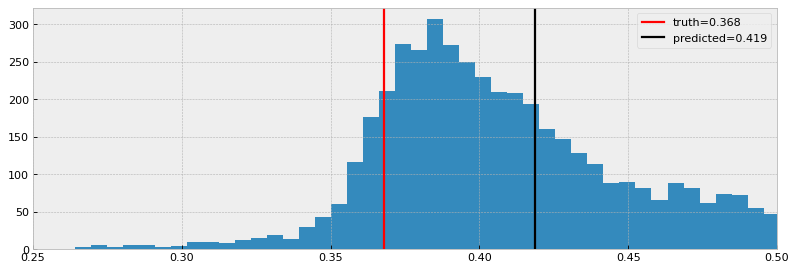

In [11]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# treatment effects
treatment_effects = counterfactuals['y_hat'][1]/counterfactuals['y_hat'][0]

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=80)
plt.hist(treatment_effects, bins=100);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

In [12]:
dtcf = DecisionTreeCounterfactual(save_explanatory=True)

In [13]:
cv_scores = dtcf.get_cross_val_scores(X, y)
print(cv_scores)

[0.54259217 0.55233764 0.55751701 0.55576795 0.52812316]


In [14]:
# fitting data to our model
dtcf.fit(X, W, y)

In [15]:
counterfactuals = dtcf.predict(X)
counterfactuals.head()

y_hat       
W         0.0    1.0
id                  
0         NaN  16.00
1   32.818182    NaN
2   25.603774    NaN
3         NaN  35.69
4   14.355191    NaN

/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/millengustavo/miniconda3/envs/causality/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


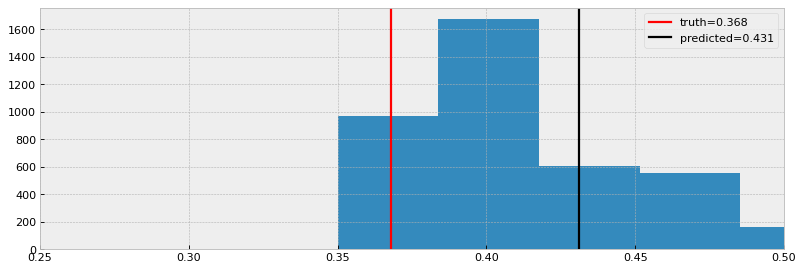

In [16]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# treatment effects
treatment_effects = counterfactuals['y_hat'][1]/counterfactuals['y_hat'][0]

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=80)
plt.hist(treatment_effects, bins=10);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

# Conclusions
- Always be skeptic of studies and investigate the data generation process
- Oftentimes, observational data may be all we got, so we must do our best to refine our hypothesis using domain knowledge to draw a Causal Diagrams before just applying ML algorithms
- Even after drawing the correct Causal Diagram we saw that the methods aren't always able to correctly estimate the causal effect. Therefore, make sure you inform the limitations of the methods you are using to estimate the causal effects